# Importing Modules

In [1]:
import os #for handling the files
import pickle #Storing numpy features (#means image features)
import numpy as np
from tqdm.notebook import tqdm #giving us a UI for how much data is processed till now (#getting an estimation of overall process)

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input #Extracting and preprocessing data
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = os.getcwd() 

# Loading VGG16 (Features extraction)

In [3]:
# Load vgg16 model
model = VGG16()
#Restructuring the models
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)#we only need the previous layer for extracting features
#summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# Extracting Features

In [4]:
# Extract features from images
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')
# for img_name in tqdm(os.listdir(directory)):
    
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose=0)
#     image_id = img_name.split('.')[0]
#     features[image_id] = feature

In [5]:
# if not features:
#     print("Features is empyt")
# else:
#     print("Features is successfully stored")

# Store features in pickle

In [6]:
# pickle.dump(features, open(os.path.join(BASE_DIR, 'features3.pkl'), 'wb'))

In [7]:
import os

pickle_path = os.path.join(BASE_DIR, 'features.pkl')

# Check if the file exists
if os.path.exists(pickle_path):
    # Check the size of the file
    file_size = os.path.getsize(pickle_path)
    print(f"Pickle file {pickle_path} exists with size: {file_size} bytes")
else:
    print(f"Pickle file {pickle_path} does not exist.")


Pickle file D:\ImageCaption\features.pkl exists with size: 133064982 bytes


In [8]:

# Load features from pickle
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
if not features:
    print("The 'features' dictionary is empty.")
else:
    print("The 'features' dictionary is not empty.")

The 'features' dictionary is not empty.


In [10]:
print(features['1000268201_693b08cb0e'])

[[2.5074754 0.        0.        ... 0.        0.        0.       ]]


# Processing Caption Data

## Loading the Caption dataset

In [11]:
# Load the captions data
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

## Seperating the image id and caption and mapping them

In [37]:
mapping = {}
for line in tqdm(captions_doc.split('\n')): #tqdm is used to show a progress bar 100%
    tokens = line.split(',') #the image name and description is seperated by a comma.
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:] #Seperating image name and caption in caption.txt
    
    image_id = image_id.split('.')[0] #take the first element in list formed by splitting using'.'
    # It is used to extract the image id alone without the format name.
    
    caption = " ".join(caption) #Combining list into a single string.
    if image_id not in mapping:
        mapping[image_id] = [] #Adding the image id that is the key alone to the dictionary.
    mapping[image_id].append(caption) #Mapping image id with the caption

  0%|          | 0/40456 [00:00<?, ?it/s]

In [38]:
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [39]:
print(mapping['1001773457_577c3a7d70'])

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


## Preprocessing the captions

In [14]:
# Preprocess text data
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i] #Extracting one caption from the list
            caption = caption.lower() #Converting into lowercase letters
            caption = re.sub('[^A-Za-z]', ' ', caption) #Replace all the characters other than [^a-z] into an empty space. (re-regular expression)
            caption = re.sub('\\s+', ' ', caption) #Removing extra spaces
            caption = 'begin ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
            #Filtering list of words that are of small length to remove noise or impurities and adding startseq and endseq
            captions[i] = caption

In [15]:
# Clean the captions
import re
clean(mapping)

In [16]:
# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

['begin child in pink dress is climbing up set of stairs in an entry way end', 'begin girl going into wooden building end', 'begin little girl climbing into wooden playhouse end', 'begin little girl climbing the stairs to her playhouse end', 'begin little girl in pink dress going into wooden cabin end']


## Storing the preprocessed captions into a list

In [17]:
# Store the preprocessed captions into a single list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
all_captions[0]

'begin child in pink dress is climbing up set of stairs in an entry way end'

In [19]:
all_captions[1:5]

['begin girl going into wooden building end',
 'begin little girl climbing into wooden playhouse end',
 'begin little girl climbing the stairs to her playhouse end',
 'begin little girl in pink dress going into wooden cabin end']

In [20]:
len(all_captions)

40455

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
vocab_size

8425

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [24]:
image_ids = list(mapping.keys()) #converting the image id's into list to get the number of unique images stored.
split = int(len(image_ids) * 0.90) #90% Split
train = image_ids[:split] #90% Training data
test = image_ids[split:] #10% Testing data

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #data_keys will be the image id's of the training part only
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0 #used for keeping track of the batch size.
    while 1:
        for key in data_keys:
            n += 1 #whenever we get a new a data we will increment it by 1.
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    # There are two inputs features and captions
                    X1.append(features[key][0]) #Features is added to X1
                    X2.append(in_seq) #Captions is added to X2
                    y.append(out_seq) #Out
            if n == batch_size:
                yield ((np.array(X1, dtype=np.float32), np.array(X2, dtype=np.int32)), np.array(y, dtype=np.float32))
                X1, X2, y = list(), list(), list()
                n = 0

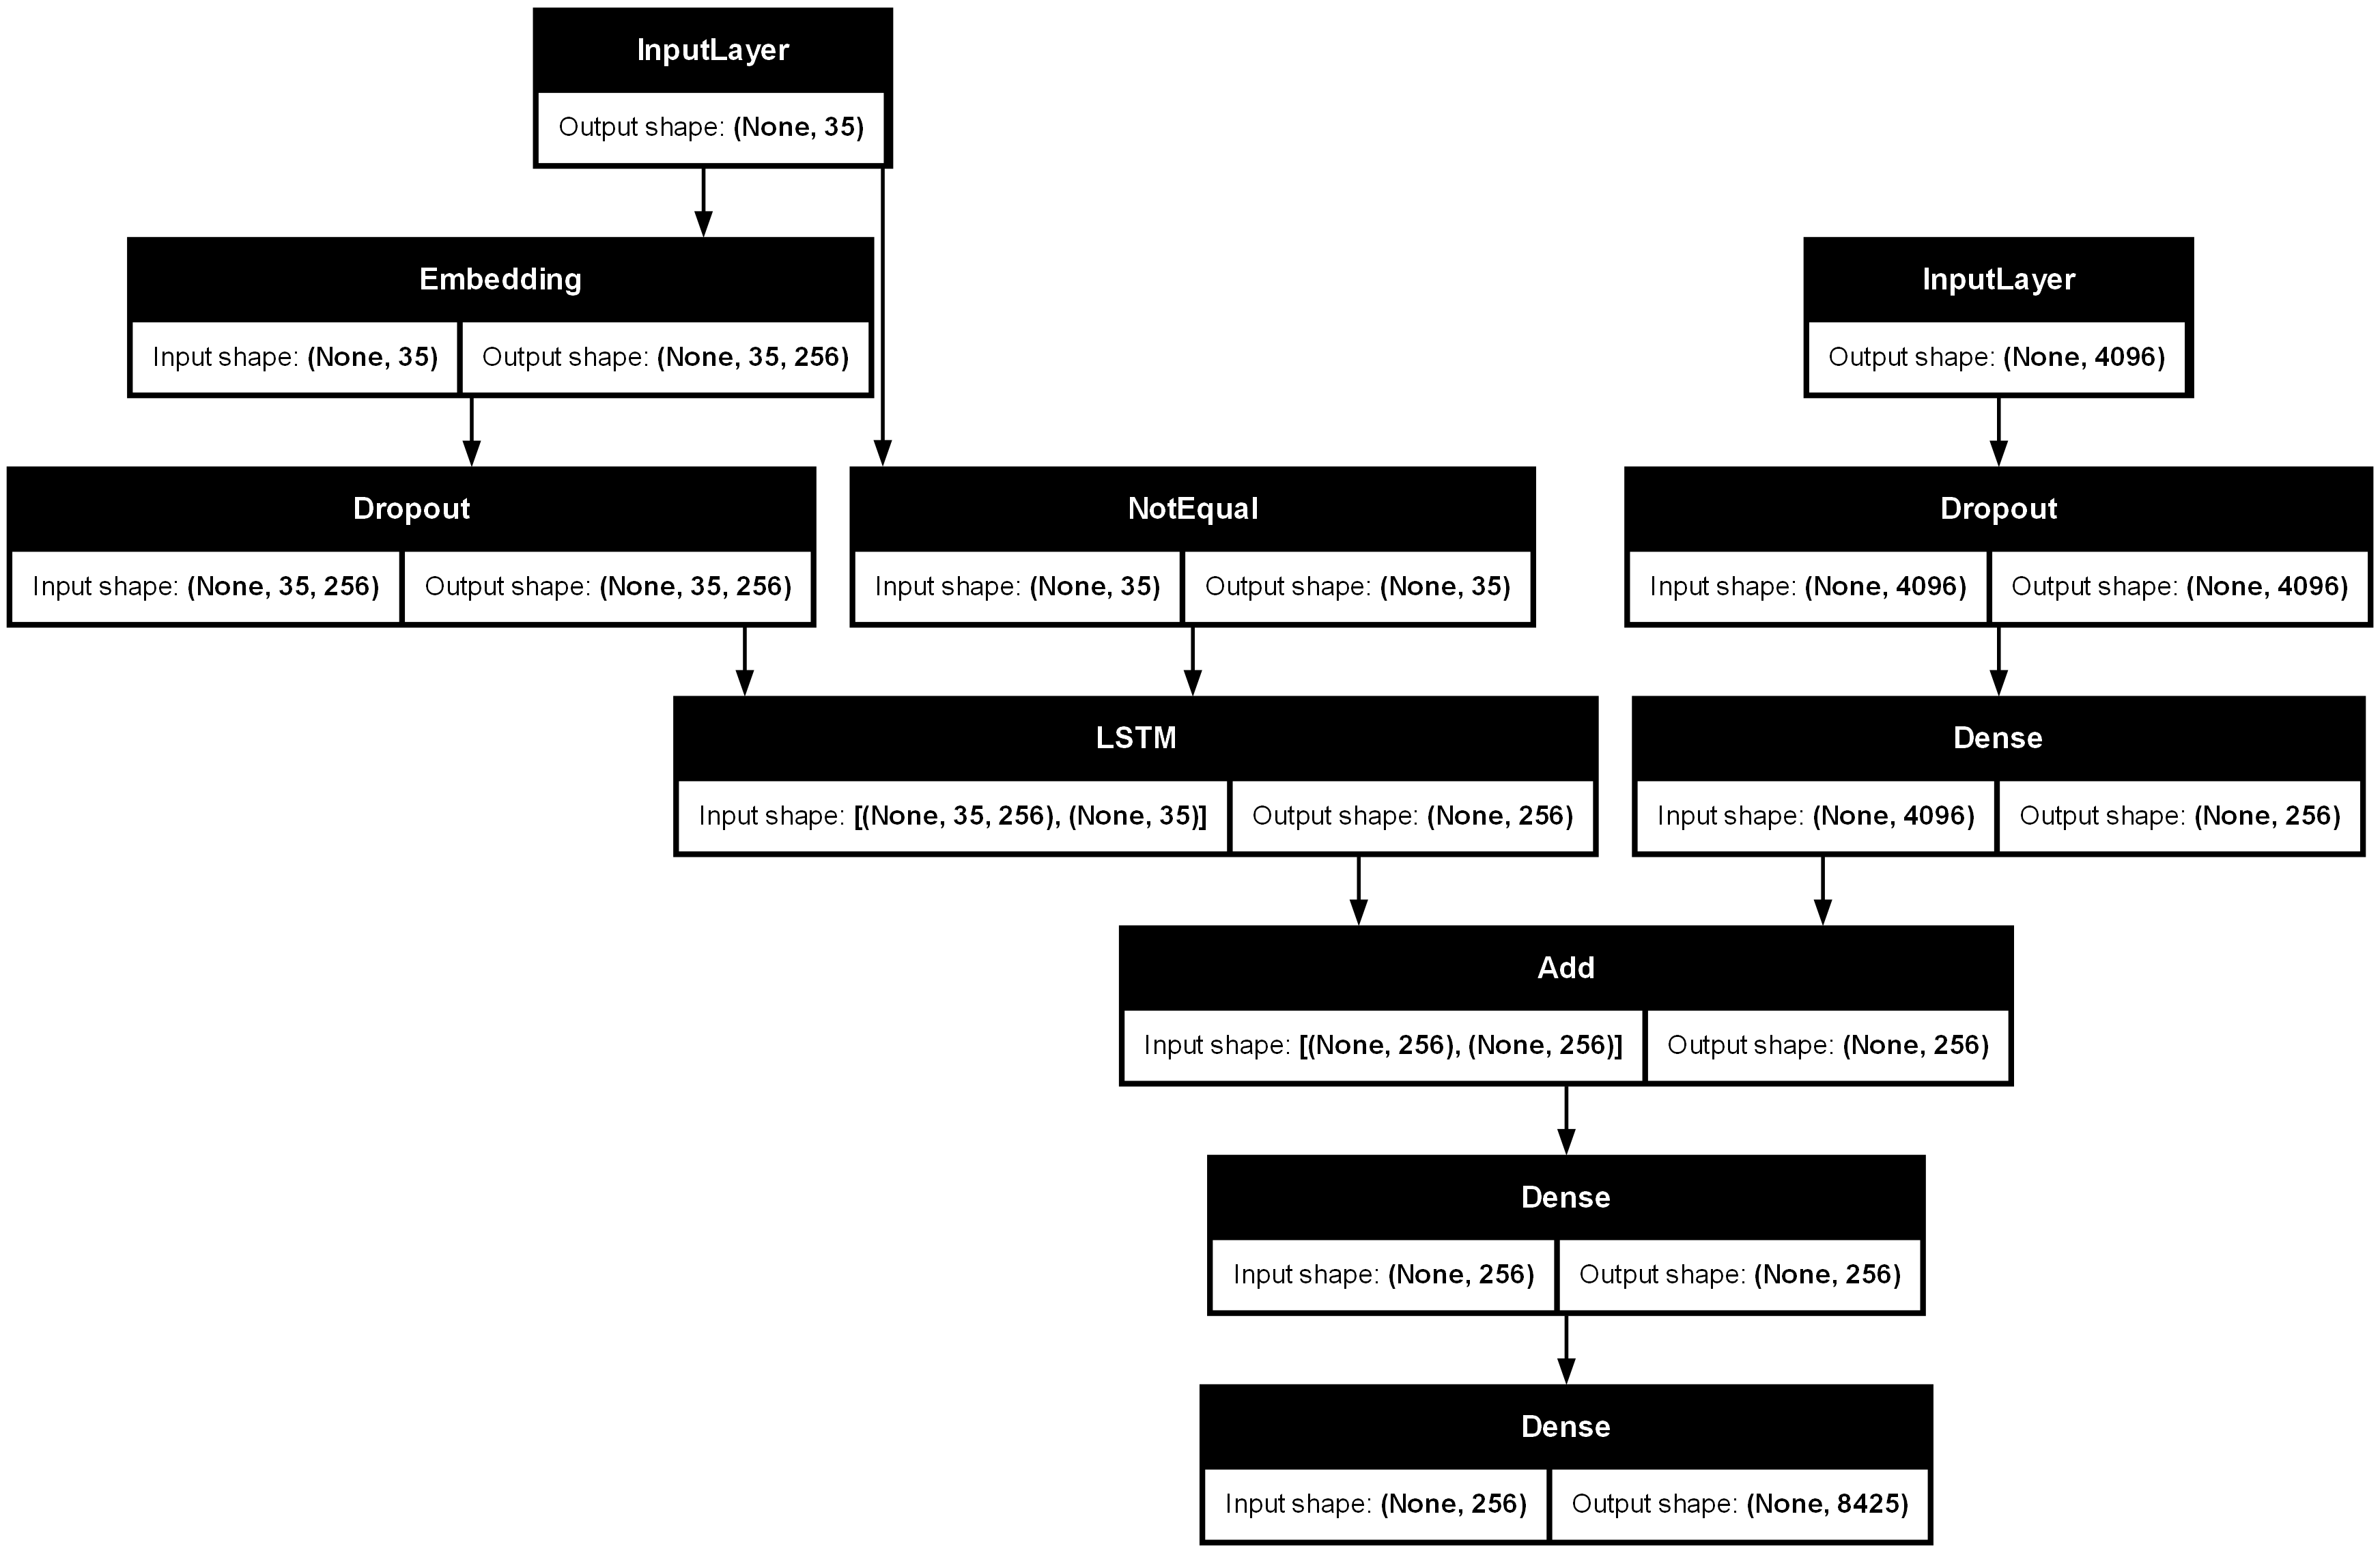

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))#Input layer 
#Refer to VGG16 model it contain 4096 feature.
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1) #fe1 is the input to the dense layer
#number of neurons = 256

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) #256 is the embedding dimension
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

fe1 = Dropout(0.4)(inputs1)

Purpose: This line applies a Dropout layer to the input.

Explanation:
- Dropout is a regularization technique used to prevent overfitting in neural networks. 
- 0.4 indicates the dropout rate, meaning 40% of the input units will be randomly set to 0 during training.
- inputs1 is the input to the Dropout layer.
- Dropout helps the model generalize better by not relying too much on any individual neuron.

The `mask_zero=True` parameter in the Embedding layer of a neural network specifies that the value 0 should be treated as a special "mask" value. This means that any occurrence of 0 in the input will be ignored during the training and inference processes. 

Certainly! This code defines a neural network model that combines image features and sequence (text) features to generate an output. This type of architecture is commonly used in tasks such as image captioning, where an image and a corresponding sequence of text (caption) are processed together.

### General Working of the Model

1. **Inputs**:
   - The model has two separate input layers: one for image features and one for text sequences.
   - `inputs1` handles the image features.
   - `inputs2` handles the text sequences.

2. **Image Feature Processing**:
   - **Input Layer**: `Input(shape=(4096,))` accepts a 4096-dimensional vector, typically extracted from a pre-trained model like VGG16.
   - **Dropout Layer**: `Dropout(0.4)` randomly sets 40% of the input units to 0 during training to prevent overfitting.
   - **Dense Layer**: `Dense(256, activation='relu')` reduces the dimensionality to 256 and applies the ReLU activation function.

3. **Sequence Feature Processing**:
   - **Input Layer**: `Input(shape=(max_length,))` accepts sequences of word indices.
   - **Embedding Layer**: `Embedding(vocab_size, 256, mask_zero=True)` converts word indices to dense 256-dimensional vectors. `mask_zero=True` ensures that padding (index 0) is ignored.
   - **Dropout Layer**: `Dropout(0.4)` randomly sets 40% of the input units to 0 during training to prevent overfitting.
   - **LSTM Layer**: `LSTM(256)` processes the sequence and learns temporal dependencies, outputting a 256-dimensional vector.

4. **Decoder Model**:
   - **Combining Features**: `add([fe2, se3])` combines the processed image features (`fe2`) and sequence features (`se3`) by element-wise addition.
   - **Dense Layer**: `Dense(256, activation='relu')` further processes the combined features with ReLU activation.
   - **Output Layer**: `Dense(vocab_size, activation='softmax')` produces the final output, which is a probability distribution over the vocabulary. This is typically used for tasks like generating the next word in a sequence.

5. **Compilation**:
   - **Loss Function**: `loss='categorical_crossentropy'` is used, which is common for classification tasks where each input belongs to one of many classes.
   - **Optimizer**: `optimizer='adam'` is an adaptive learning rate optimization algorithm that is widely used for training deep learning models.

### General Working Flow

1. **Input Handling**:
   - Image features and text sequences are inputted into their respective branches of the model.

2. **Feature Extraction**:
   - Image features are processed through a dropout and dense layer to extract relevant information.
   - Text sequences are processed through an embedding layer, dropout, and LSTM to capture the sequential information.

3. **Feature Combination**:
   - The processed features from the image and text branches are combined.

4. **Decoding**:
   - The combined features are further processed to produce a final output that is a probability distribution over the vocabulary.

5. **Training**:
   - The model is compiled with a loss function and optimizer.
   - The model can be trained on data where each sample includes both image features and corresponding text sequences.

This type of model is useful for tasks that require integrating and processing different modalities of data, such as combining visual and textual information to generate meaningful outputs.

In [27]:
import tensorflow as tf
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32), tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)


In [28]:
def create_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )
    return dataset


In [29]:
# epochs = 15
# batch_size = 64
# steps = len(train) // batch_size

# # Create dataset
# dataset = create_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# for epoch in range(epochs):
#     # Create data generator for this epoch
#     # generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
#     # Fit the model for one epoch
#     model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)


In [30]:
# model.save('image_caption_generator.h5')

## Generating image captions

In [31]:
model.load_weights('image_caption_generator.h5')

In [32]:
def index_to_word(integer, tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
#generate captions for an image
def predict_caption(model,image,tokenizer,max_length):
    in_text = 'begin'
    for i in range(max_length):
        #convert sequence into and integer
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_length)
        #Now predicting next word
        yword = model.predict([image,sequence],verbose=0)

        yword = np.argmax(yword) #Return the word the most probability

        #converting the index value to word
        word = index_to_word(yword,tokenizer)

        #stop if word not found
        if word is None:
            break

        #Append the word to the existing word
        in_text += ' '+word

        if word == 'end':
            break;
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual,predict = list(),list()
for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predicting the caption for image
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    #splitting the sentence into words
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    predict.append(y_pred.split())

#calculate BLEU score
print("BLEU-1: %f" % corpus_blue(actual,predicted, weights=(1.0,0,0,0)))
print("BLEU-1: %f" % corpus_blue(actual,predicted, weights=(0.5,0.5,0,0)))


  0%|          | 0/810 [00:00<?, ?it/s]

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)
    
    captions = mapping[image_id]
    print("Actual Caption:\n")
    for caption in captions:
        print(caption)
   
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("\nPredicted Caption:\n")
    print(y_pred)
    


Actual Caption:

begin little girl covered in paint sits in front of painted rainbow with her hands in bowl end
begin little girl is sitting in front of large painted rainbow end
begin small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
begin there is girl with pigtails sitting in front of rainbow painting end
begin young girl with pigtails painting outside in the grass end


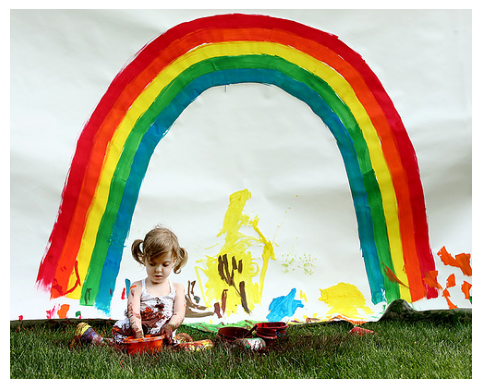


Predicted Caption:

begin little girl in pigtails playing in the air end


In [35]:
generate_caption("1002674143_1b742ab4b8.jpg")